In [2]:
import xarray as xr 
import numpy as np
import pandas as pd
import re
import numpy.matlib as npm
from matplotlib import colors
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy import optimize
import json
import random as rd

In [3]:
def read_mgrid(filename, *args):

    file = xr.open_dataset(filename)

    nr = int(file.ir)
    nz = int(file.jz)
    nphi = int(file.kp)
    nfp = int(file.nfp)

    nextcur = int(file.nextcur)
    rmin = file.rmin
    rmax = file.rmax
    zmin = file.zmin
    zmax = file.zmax
    curlabel = file.coil_group
    

    br = np.zeros(shape=(nr,nz,nphi,nextcur))
    bphi= np.zeros(shape=(nr,nz,nphi,nextcur))
    bz = np.zeros(shape=(nr,nz,nphi,nextcur))
    bx = np.zeros(shape=(nr,nz,nphi,nextcur))
    by = np.zeros(shape=(nr,nz,nphi,nextcur))

    for i in range(0,nextcur):
        br[:,:,:,i] = np.array(file['br_%03d' % (i+1)]).T
        bphi[:,:,:,i] = np.array(file['bp_%03d' % (i+1)]).T
        bz[:,:,:,i] = np.array(file['bz_%03d' % (i+1)]).T
    
    phi = np.arange(start = 0, stop = 2*np.pi/nfp, step = 2*np.pi/(nfp*nphi))    
    raxis = np.linspace(rmin, rmax, num = nr, endpoint = True)
    zaxis = np.linspace(zmin, zmax, num = nz, endpoint = True)

    for k in range(1,nphi):
        bx[:,:,k,:] = np.multiply(br[:,:,k,:],np.cos(phi[k]))-np.multiply(bphi[:,:,k,:],np.sin(phi[k]))
        by[:,:,k,:] = -np.multiply(br[:,:,k,:],np.sin(phi[k]))+np.multiply(bphi[:,:,k,:],np.cos(phi[k]))

    ds = xr.Dataset({
        'br': xr.DataArray(
                data = br, 
                dims = ['nr','nz','nphi','nextcur'],
            ),
        'bphi': xr.DataArray(
                data = bphi, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'bx': xr.DataArray(
                data = bx, 
                dims = ['nr','nz','nphi','nextcur'],
            ),
        
        'by': xr.DataArray(
                data = by, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'bz': xr.DataArray(
                data = bz, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'nfp':nfp, 

        'raxis': xr.DataArray(
                data = raxis,
                dims = ['R']
        ),

        'zaxis': xr.DataArray(
                data = zaxis,
                dims = ['Z']
        ),

        'phi': xr.DataArray(
                data = phi,
                dims = ['phi']
        ),

        'rmin':rmin, 
        'rmax':rmax, 
        'zmin':zmin,
        'zmax':zmax,

        'curlabel': xr.DataArray(
            data = curlabel
            )
    })

    return ds

In [4]:
data=read_mgrid('mgrid_MEDUSACR2.nc')

In [5]:
data

<xarray.Dataset>
Dimensions:   (R: 201, Z: 201, external_coil_groups: 8, nextcur: 8, nphi: 36, nr: 201, nz: 201, phi: 36)
Coordinates:
  * phi       (phi) float64 0.0 0.1745 0.3491 0.5236 ... 5.585 5.76 5.934 6.109
Dimensions without coordinates: R, Z, external_coil_groups, nextcur, nphi, nr, nz
Data variables: (12/13)
    br        (nr, nz, nphi, nextcur) float64 0.0 -4.922e-09 ... -3.439e-09
    bphi      (nr, nz, nphi, nextcur) float64 -9.705e-10 4.914e-09 ... 2.375e-09
    bx        (nr, nz, nphi, nextcur) float64 0.0 0.0 ... -2.924e-09 -2.974e-09
    by        (nr, nz, nphi, nextcur) float64 0.0 0.0 ... -1.039e-09 1.741e-09
    bz        (nr, nz, nphi, nextcur) float64 0.0 2.634e-13 ... 9.767e-12
    nfp       int32 1
    ...        ...
    zaxis     (Z) float64 -0.2 -0.198 -0.196 -0.194 ... 0.194 0.196 0.198 0.2
    rmin      float64 0.03
    rmax      float64 0.28
    zmin      float64 -0.2
    zmax      float64 0.2
    curlabel  (external_coil_groups) |S30 b'tcero                         ' ....

In [6]:
medusa_coords=np.loadtxt("coordenadasMEDUSA.txt",delimiter="\t")

In [7]:
extcur=5.00000000000000E+03*np.ones(8)

In [8]:
bphi = np.zeros(data.bphi.shape)
for i in range(data.dims['nextcur']):
    bphi[:,:,:,i] = np.multiply(data.bphi[:,:,:,i],extcur[i])
bphit = np.sum(bphi,axis = 3)

In [9]:
Rx,zy=np.meshgrid(data.raxis,data.zaxis)

In [42]:
dA=(np.max(Rx)-np.min(Rx))*(np.max(zy)-np.min(zy))/len(bphit[:,:,0].T)**2
(dA*bphit[:,:,0].T).sum()

5.7993365057882e-06

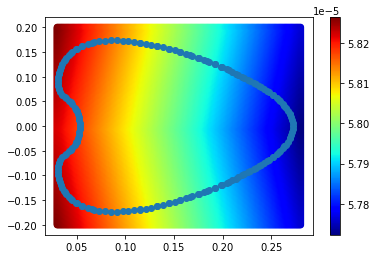

In [10]:
plt.scatter(Rx,zy,c=bphit[:,:,0].T,cmap='jet')
plt.colorbar()
plt.scatter(medusa_coords[:,0],medusa_coords[:,1])

In [11]:
R_sample=[]
z_sample=[]
Bphi_sample=[]
for iPunto in range(1000):
    np.random.seed(np.random.randint(10**4,10**8))
    i=np.random.randint(0,len(data.raxis))
    j=np.random.randint(0,len(data.raxis))
    R_sample.append(Rx[i,j])
    z_sample.append(zy[i,j])
    Bphi_sample.append(bphit[:,:,0].T[i,j])

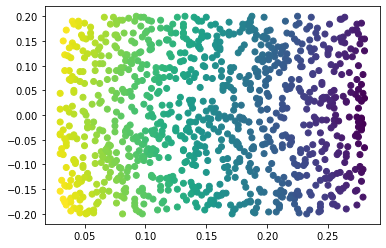

In [12]:
plt.scatter(R_sample,z_sample,c=Bphi_sample)

In [13]:
from scipy import optimize

In [14]:
def B_q(X,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O):
    '''
    Función que calcula el valor de una respuesta a partir de un modelo lineal genera con interacciones de orden 3.
    
    Parámetros de entrada:
    ----------------------
    X: Una tupla que contiene dos arreglos que con los valores de las variables independientes.
    A,B,C,D,E,F,G,H,I,J: Son los coeficientes de peso de la interacción.
    
    Salida:
    ----------------------
    Un arreglo con los valores de la función para los dos arreglos brindados en X.
    '''
    return (A*X[0]**4+B*X[1]**4+C*X[0]**3*X[1]+D*X[0]**2*X[1]**2+E*X[0]*X[1]**3+F*X[0]**3+G*X[1]**3+H*X[0]**2*X[1]+I*X[0]*X[1]**2+J*X[0]**2+K*X[1]**2+L*X[0]*X[1]+M*X[0]+N*X[1]+O)

In [15]:
CoefsPhi,CovPhi=optimize.curve_fit(B_q,(R_sample,z_sample),Bphi_sample)

In [16]:
def ComponentesCampo(X,Coefs):
    A=Coefs[0]
    B=Coefs[1]
    C=Coefs[2]
    D=Coefs[3]
    E=Coefs[4]
    F=Coefs[5]
    G=Coefs[6]
    H=Coefs[7]
    I=Coefs[8]
    J=Coefs[9]
    K=Coefs[10]
    L=Coefs[11]
    M=Coefs[12]
    N=Coefs[13]
    O=Coefs[14]
    Bq=A*X[0]**4+B*X[1]**4+C*X[0]**3*X[1]+D*X[0]**2*X[1]**2+E*X[0]*X[1]**3+F*X[0]**3+G*X[1]**3+H*X[0]**2*X[1]+I*X[0]*X[1]**2+J*X[0]**2+K*X[1]**2+L*X[0]*X[1]+M*X[0]+N*X[1]+O
    plt.scatter(X[0],X[1],c=Bq,cmap='jet')
    plt.xlabel('R [m]')
    plt.ylabel('z [m]')
    plt.colorbar()
    plt.show()
    return Bq

In [17]:
z_prueba=np.arange(-0.2,0.2+0.0004,0.004)
R_prueba=np.arange(0,0.30+0.0003,0.003)
Rx_prueba,zy_prueba=np.meshgrid(R_prueba,z_prueba)

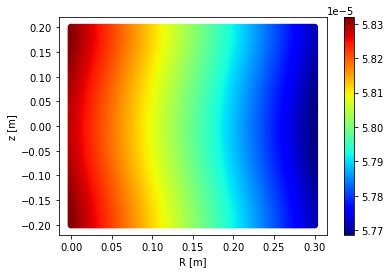

In [18]:
Bphi_calculado=ComponentesCampo((Rx_prueba,zy_prueba),CoefsPhi)

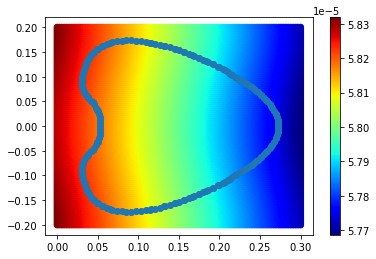

In [19]:
plt.scatter(Rx_prueba,zy_prueba,c=Bphi_calculado,cmap='jet')
plt.colorbar()
plt.scatter(medusa_coords[:,0],medusa_coords[:,1])

In [20]:
def IntegralMonteCarlo(Bq,N):
    R=[]
    z=[]
    for inv in range(N):
        np.random.seed(np.random.randint(10**4,10**8))
        R.append((np.max(medusa_coords[:,0])-np.min(medusa_coords[:,0]))*np.random.random()+np.min(medusa_coords[:,0]))
        z.append((np.max(medusa_coords[:,1])-np.min(medusa_coords[:,1]))*np.random.random()+np.min(medusa_coords[:,1]))
    R=np.array(R)
    z=np.array(z)
    Flujo=ComponentesCampo((np.array(R),np.array(z)),CoefsPhi).sum()*(np.max(medusa_coords[:,0])-np.min(medusa_coords[:,0]))*(np.max(medusa_coords[:,1])-np.min(medusa_coords[:,1]))/N
    return (Flujo,1/np.sqrt(N))

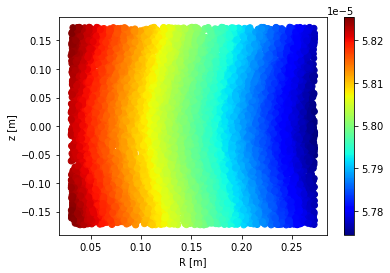

(4.8613671180018864e-06, 0.01)

In [21]:
IntegralMonteCarlo(ComponentesCampo,10000)

In [22]:
Dict_RzBphi={'R':Rx_prueba.tolist(),'z':zy_prueba.tolist(),'Bphi':Bphi_calculado.tolist()}
with open("C:/Users/Dell/Documents/Repositories/plasmatec/makegrid_python/Dict_RzBphi.txt", 'w') as file:
     file.write(json.dumps(Dict_RzBphi))

In [23]:
medusa_r=np.sqrt(medusa_coords[:,0]**2+medusa_coords[:,1]**2)

In [24]:
medusa_theta=np.arctan(medusa_coords[:,1]/medusa_coords[:,0])

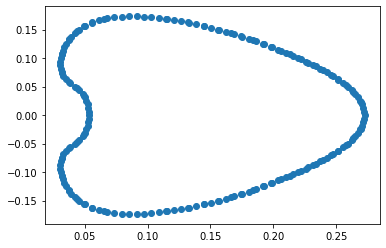

In [25]:
plt.scatter(medusa_r*np.cos(medusa_theta),medusa_r*np.sin(medusa_theta))

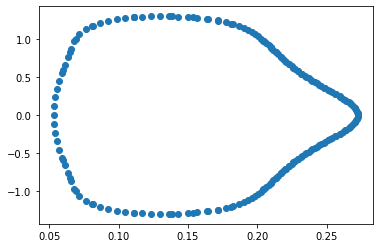

In [26]:
plt.scatter(medusa_r,medusa_theta)

In [27]:
medusa_polar_pos=[]
medusa_polar_neg=[]
for j in range(len(medusa_theta)):
    if medusa_theta[j]>=0:
        medusa_polar_pos.append([medusa_r[j],medusa_theta[j]])
    else:
        medusa_polar_neg.append([medusa_r[j],medusa_theta[j]])
medusa_polar_pos=np.array(medusa_polar_pos)
medusa_polar_neg=np.array(medusa_polar_neg)

C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


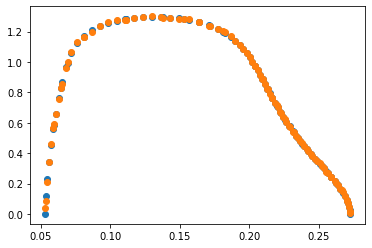

In [28]:
plt.scatter(medusa_polar_pos[:,0],medusa_polar_pos[:,1])
plt.scatter(medusa_polar_pos[:,0],np.polyval(np.polyfit(medusa_polar_pos[:,0],medusa_polar_pos[:,1],(len(medusa_polar_pos[:,1]-1))),medusa_polar_pos[:,0]))

C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


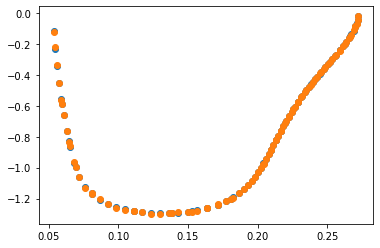

In [29]:
plt.scatter(medusa_polar_neg[:,0],medusa_polar_neg[:,1])
plt.scatter(medusa_polar_neg[:,0],np.polyval(np.polyfit(medusa_polar_neg[:,0],medusa_polar_neg[:,1],(len(medusa_polar_neg[:,1]-1))),medusa_polar_neg[:,0]))

In [30]:
p_pos=np.polyfit(medusa_polar_pos[:,0],medusa_polar_pos[:,1],(len(medusa_polar_pos[:,1]-1)))

C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
p_neg=np.polyfit(medusa_polar_neg[:,0],medusa_polar_neg[:,1],(len(medusa_polar_neg[:,1]-1)))

C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


# Estimación de la superficie transversal por Monte Carlo

In [32]:
def MonteCarloÁrea(nTiros):
    nAciertos=0
    contador=0
    At=(np.max(Rx)-np.min(Rx))*(np.max(zy)-np.min(zy))
    while contador<=nTiros:
        rd.seed()
        R=rd.uniform(np.min(Rx),np.max(Rx))
        z=rd.uniform(np.min(zy),np.max(zy))
        r=np.sqrt(R**2+z**2)
        theta=np.arctan(z/R)
        if theta<0 and np.min(medusa_r)<=r<=np.max(medusa_r):
            theta_eval=np.polyval(p_neg,r)
            if theta_eval<theta:
                nAciertos+=1
            else:
                pass
        else:
            theta_eval=np.polyval(p_pos,r)
            if theta_eval>theta and np.min(medusa_r)<=r<=np.max(medusa_r):
                nAciertos+=1
            else:
                pass
        contador+=1
    A=nAciertos*At/nTiros
    return A

In [33]:
AT=MonteCarloÁrea(1000)
AT

0.06390000000000001

# Estimación del Flujo magnético a través de la superficie transversal por Monte Carlo

In [34]:
def MonteCarloFlujoÁrea(N):
    R=[]
    z=[]
    for i in range(N):
        rd.seed()
        R_random=rd.uniform(np.min(medusa_coords[:,0]),np.max(medusa_coords[:,0]))
        z_random=rd.uniform(np.min(medusa_coords[:,1]),np.max(medusa_coords[:,1]))
        r=np.sqrt(R_random**2+z_random**2)
        theta=np.arctan(z_random/R_random)
        if theta<0:
            theta_eval=np.polyval(p_neg,r)
            if theta_eval<theta and np.min(medusa_r)<=r<=np.max(medusa_r):
                z.append(z_random)
                R.append(R_random)
            else:
                pass
        else:
            theta_eval=np.polyval(p_pos,r)
            if theta_eval>theta and np.min(medusa_r)<=r<=np.max(medusa_r):
                z.append(z_random)
                R.append(R_random)
            else:
                pass
    R=np.array(R)
    z=np.array(z)
    Flujo=ComponentesCampo((np.array(R),np.array(z)),CoefsPhi).sum()*(np.max(medusa_coords[:,0])-np.min(medusa_coords[:,0]))*(np.max(medusa_coords[:,1])-np.min(medusa_coords[:,1]))/N
    return Flujo,R,z

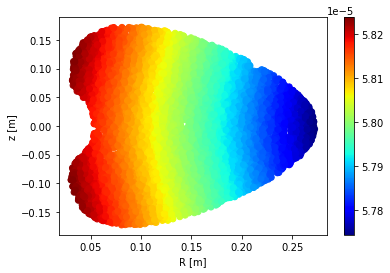

3.552573686474865e-06

In [35]:
flujo_medusa,Rx_nuevo,zy_nuevo=MonteCarloFlujoÁrea(10000)
flujo_medusa

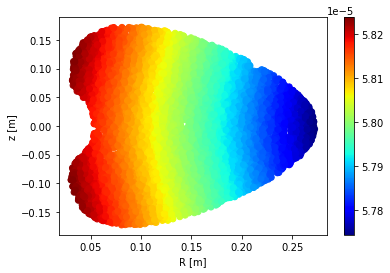

In [36]:
Bphi_nuevo=ComponentesCampo((Rx_nuevo,zy_nuevo),CoefsPhi)

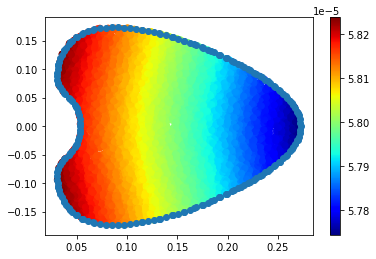

In [37]:
plt.scatter(Rx_nuevo,zy_nuevo,c=Bphi_nuevo,cmap='jet')
plt.colorbar()
plt.scatter(medusa_coords[:,0],medusa_coords[:,1])

In [38]:
# Chequeando
dA=AT/len(Bphi_nuevo)
(dA*Bphi_nuevo).sum()

3.7077971586512256e-06